<a href="https://colab.research.google.com/github/shumono/skills-github-pages/blob/main/vital_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 心拍数と酸素飽和度の時間帯おける変化
2025/09/14  
情報形成デザイン5B  
DS243100 岡田 修門

## 制作について
最近気になっている健康をテーマにし、ウエラブルデバイスが取得したデータを可視化する。  

---
    
## データ  
Apple Watch が常時取得している、心拍数と酸素飽和度と日時のデータを利用。  

---

## 方法（下準備）   
    1. Apple ヘルスケアからXMLデータをエクスポート  
    2. iPhoneからPCへデータをコピー
    3. XMLデータのサイズが大きすぎるので、心拍数と酸素飽和度にデータを絞り、csvデータに加工する

---

## 方法（本番）  
    4. XMLを読み込み
    5. レコードからデータフレームを作成
    6. データフレーム上で値を有意な形に変換
    7. 統計的に異常値を排除
    8. データフレーム上でグループ化（時間、曜日と心拍数平均又は酸素飽和度平均）若しくは（時間、月と心拍数平均又は酸素飽和度平均）
    9. ヒートマップを描画

---

## スケッチ
<br><img src="https://shumono.github.io/skills-github-pages/data/IMG_7153.jpeg" align="center" width="75%">  

---

## コードの概要
このPythonスクリプトは、Apple HealthのXMLデータから抽出した心拍数と酸素飽和度（SpO2）のデータを、時間帯ごとの曜日別・月別の平均値として集計し、**ヒートマップ**で可視化することを目的としています。

---

## プログラムの目的 (Program Objective)

このスクリプトの主な目的は、特定のユーザーのバイタルデータ（心拍数とSpO2）が、1日の時間帯、曜日、そして月によってどのように変動するかを視覚的に分析することです。生成されるヒートマップは、色の濃淡を通じてデータの平均値を示し、生活リズムや季節による身体の変化を直感的に把握できるようにします。

---

## プログラムの主要な機能 (Main Program Functions)

### 1. データ抽出と前処理 (Data Extraction and Preprocessing)

* **XMLからCSVへの変換 (`extract_and_save_data`関数):**
    * `parth_xml`フラグが`1`に設定されている場合、Apple HealthのXMLファイル（`export.xml`）を読み込み、心拍数と酸素飽和度のレコードを抽出します。
    * 抽出されたデータは、日付をインデックス、心拍数とSpO2を列として持つCSVファイル（`subset_export.xml.csv`）として保存されます。
* **データの読み込み:**
    * `parth_xml`が`0`の場合、スクリプトは指定されたGitHub PagesのURLからCSVデータを直接読み込みます。
* **データのクリーニングと整形:**
    * 読み込んだデータは、`HeartRate`と`SpO2`の列を数値型に変換します（`SpO2`は`%`単位に変換するため100を乗算）。
    * 日付情報から**曜日 (`weekday`)**、**月 (`Month`)**、**時間 (`Hour`)** の3つの新しい列を作成します。
* **外れ値の除去 (`filter_outliers_iqr`関数):**
    * **IQR（四分位範囲）**法を用いて、心拍数とSpO2のデータから極端な外れ値を除去します。これにより、異常な測定値が分析結果に影響を与えるのを防ぎます。
* **カテゴリカルデータの整形:**
    * 曜日の英語名を日本語に変換し、曜日と月を**順序付きカテゴリ変数**として設定します。これにより、ヒートマップの軸が正しい順序で表示されるようになります。

### 2. ヒートマップの生成と保存 (Heatmap Generation and Saving)

* **集計 (Pivot Table作成):**
    * `pandas.pivot_table`に似た`groupby().unstack()`というメソッドを使い、各時間帯の心拍数とSpO2の平均値を、曜日別および月別に集計した表（ピボットテーブル）を作成します。
* **ヒートマップの描画 (`create_heatmap`関数):**
    * `seaborn.heatmap`ライブラリを利用して、前述の集計結果を視覚化します。
    * 以下の4種類のヒートマップが生成され、PNGファイルとして保存されます。
        * **心拍数**の曜日別ヒートマップ
        * **酸素飽和度**の曜日別ヒートマップ
        * **心拍数**の月別ヒートマップ
        * **酸素飽和度**の月別ヒートマップ
* **視覚的要素:**
    * `plasma`や`viridis`などのカラーマップを使用し、値の大小を色の濃淡で表現します。
    * タイトル、軸ラベル、カラーバーラベルを適切に設定し、グラフの可読性を高めます。



heartrate_weekday_heatmap.png が作成されました。
spo2_weekday_heatmap.png が作成されました。
heartrate_month_heatmap.png が作成されました。
spo2_month_heatmap.png が作成されました。


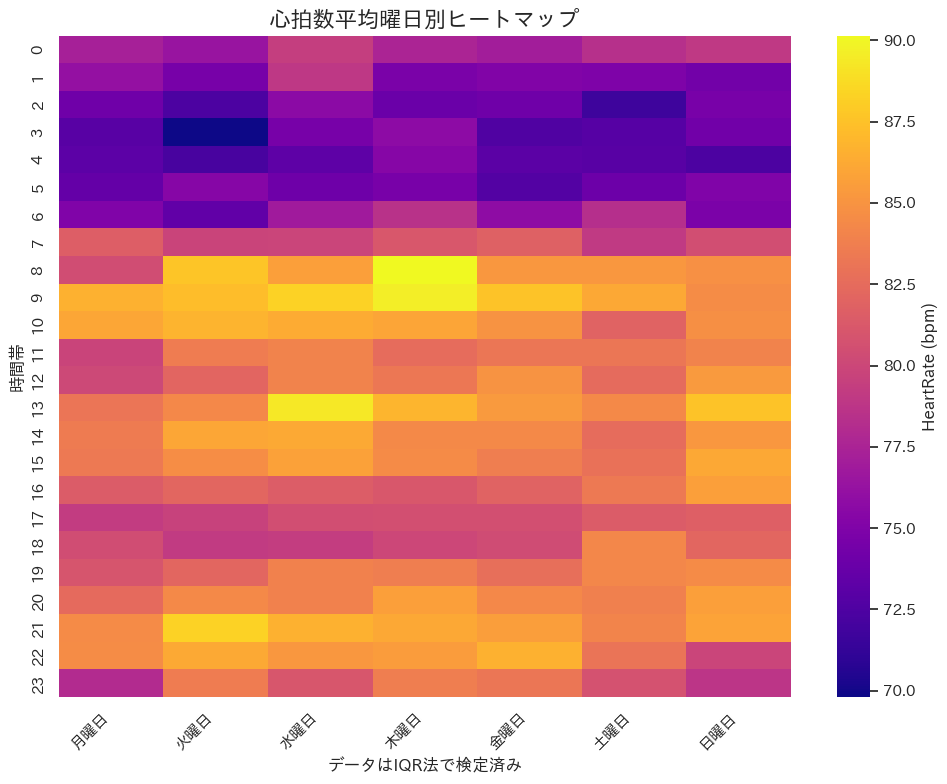

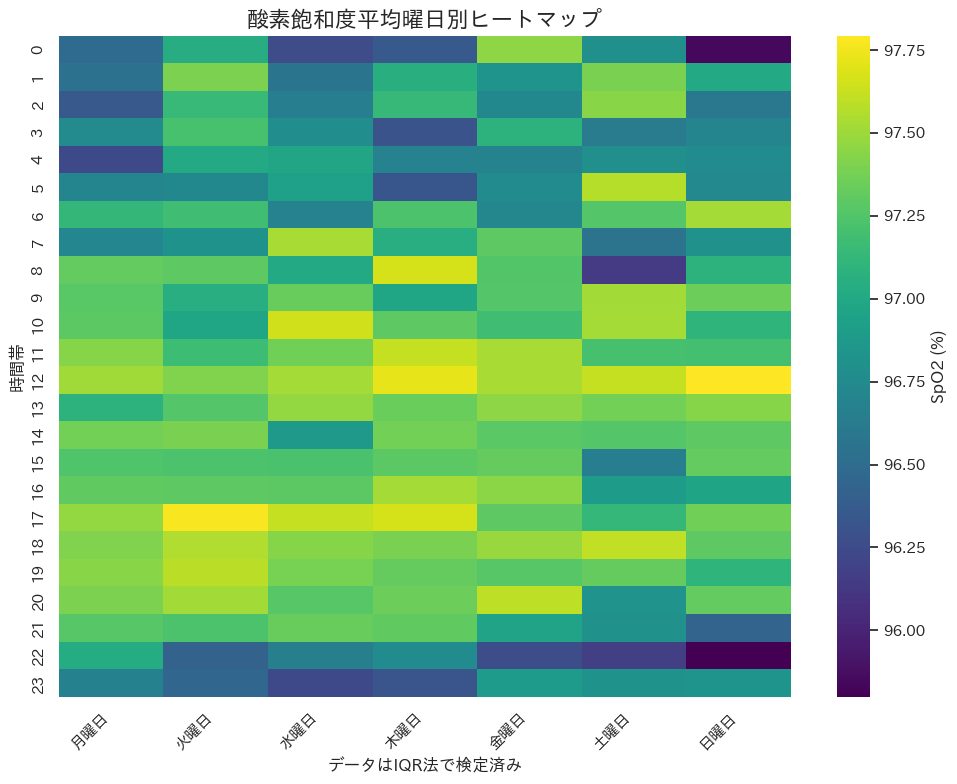

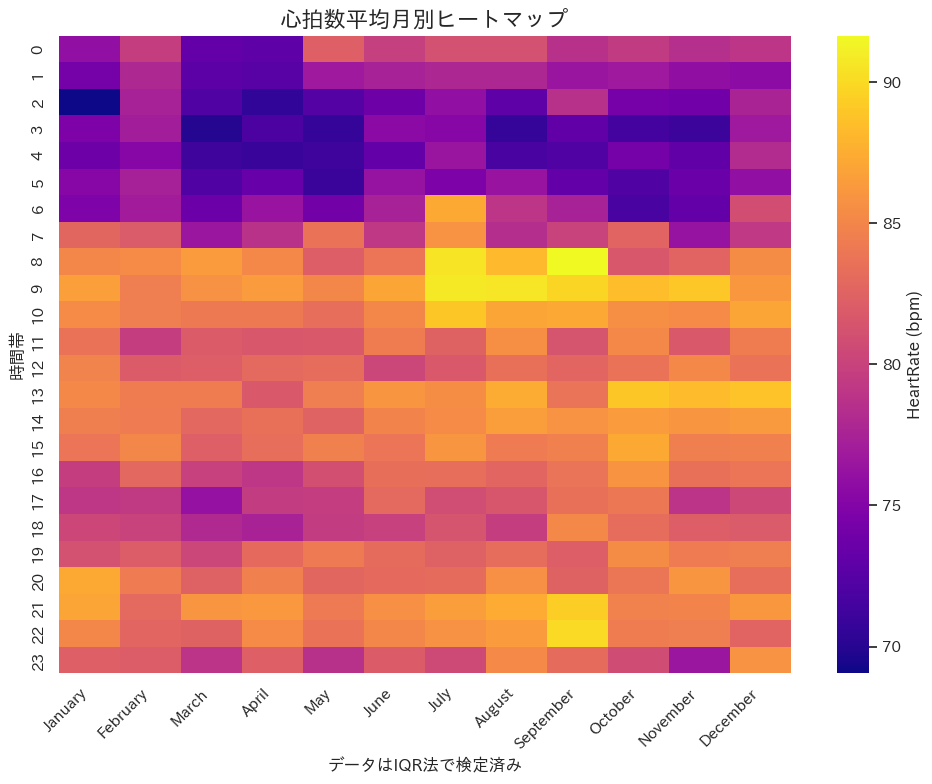

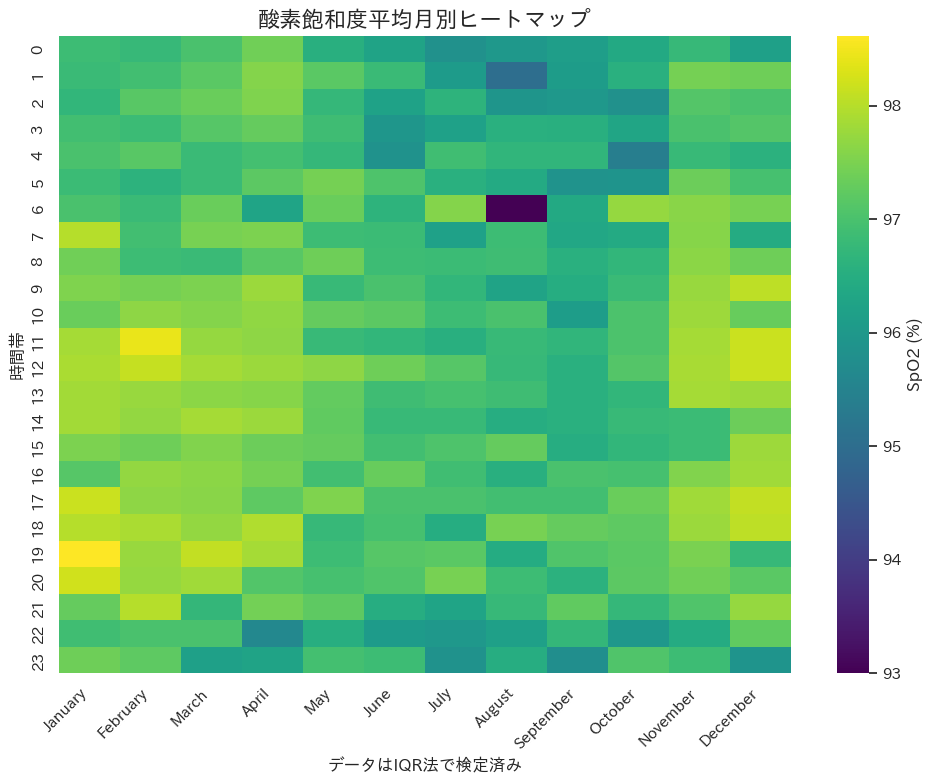

In [ ]:
'''
Filename: vital_heatmap.ipynb
Description:
情報形成デザイン5B 課題
時間帯の心拍数と酸素飽和度を曜日別、月別でヒートマップ化
'''

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import io
import xml.etree.ElementTree as ET
import sys
import warnings
sns.set(font='IPAexGothic') # 日本語フォントを指定する重要

# 警告一時停止
warnings.filterwarnings('ignore')

def extract_and_save_data(input_xml_path, output_csv_path):
    """
    Apple HealthのXMLファイルから特定のデータを抽出し、CSVファイルとして保存する関数。

    Args:
        input_xml_path (str): 入力XMLファイルのパス。
        output_csv_path (str): 出力CSVファイルのパス。
    """
    try:
        # XMLファイルを解析
        tree = ET.parse(input_xml_path)
        root = tree.getroot()
    except FileNotFoundError:
        print(f"エラー: ファイル '{input_xml_path}' が見つかりませんでした。正しいファイルパスを指定してください。")
        return
    except ET.ParseError as e:
        print(f"エラー: XMLファイルの解析に失敗しました。ファイルが破損しているか、形式が不正です。詳細: {e}")
        return

    for elem in root.iter():
        if '}' in elem.tag:
            elem.tag = elem.tag.split('}', 1)[1]

    records_heart_rate = root.findall('.//Record[@type="HKQuantityTypeIdentifierHeartRate"]')
    records_spo2 = root.findall('.//Record[@type="HKQuantityTypeIdentifierOxygenSaturation"]')
    data = {}

    for record in records_heart_rate:
        start_date = record.get('startDate')
        if start_date not in data:
            data[start_date] = {'HeartRate': None, 'SpO2': None}
        data[start_date]['HeartRate'] = record.get('value')

    for record in records_spo2:
        start_date = record.get('startDate')
        if start_date not in data:
            data[start_date] = {'HeartRate': None, 'SpO2': None}
        data[start_date]['SpO2'] = record.get('value')

    df = pd.DataFrame.from_dict(data, orient='index')

    if df.empty:
        print("警告: 抽出できるレコードが見つかりませんでした。")
        return

    df.to_csv(output_csv_path, index=True, index_label='Date')

    print(f"成功: {len(df)} 件のレコードを '{output_csv_path}' に保存しました。\n指定のパスにファイルをアップロードして下さい。\nparth_xmlの値は 0 に戻して下さい。")

def filter_outliers_iqr(df, columns, factor=1.5):
    """指定された列の異常値をIQR法で除去する関数。"""
    filtered_df = df.copy()
    for column in columns:
        Q1 = filtered_df[column].quantile(0.25)
        Q3 = filtered_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        filtered_df = filtered_df[
            (filtered_df[column] >= lower_bound) &
            (filtered_df[column] <= upper_bound)
        ]
    return filtered_df

def create_heatmap(data, title, xlabel, ylabel, cmap, cbar_label, filename):
    """ヒートマップを生成して保存する関数。"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, cmap=cmap, cbar_kws={'label': cbar_label})
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    print(f"{filename} が作成されました。")

# データの生成フラグ
parth_xml = 0 #生成するなら 1

# ファイルのパス
input_xml_file = 'csv/apple_health_export/export.xml'
output_csv_file = 'csv/subset_export.xml.csv'

# プログラム全体をtry-exceptブロックでラップし、SystemExitを捕捉
try:
    # XMLをCSVに変換
    if parth_xml:
        extract_and_save_data(input_xml_file, output_csv_file)
        sys.exit()

    # データの読み込み
    url = 'https://shumono.github.io/skills-github-pages/data/subset_export.xml.csv'

    try:
        response = requests.get(url)
        response.raise_for_status()
        csvdata = io.StringIO(response.text)
        df = pd.read_csv(csvdata, index_col=0, parse_dates=True)
    except requests.exceptions.RequestException as e:
        print(f"エラーが発生しました: {e}")
        print("URLが正しいか、またはネットワーク接続を確認してください。")
        sys.exit(1)

    # データ前処理
    df = df.reset_index().rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    df['HeartRate'] = pd.to_numeric(df['HeartRate'], errors='coerce')
    df['SpO2'] = pd.to_numeric(df['SpO2'], errors='coerce') * 100

    df['weekday'] = df['Date'].dt.day_name()
    df['Month'] = df['Date'].dt.month_name()
    df['Hour'] = df['Date'].dt.hour

    df_filtered = filter_outliers_iqr(df, ['SpO2', 'HeartRate'])
    df = df_filtered

    weekday_mapping = {
        'Monday': '月曜日', 'Tuesday': '火曜日', 'Wednesday': '水曜日', 'Thursday': '木曜日',
        'Friday': '金曜日', 'Saturday': '土曜日', 'Sunday': '日曜日'
    }
    df['weekday'] = df['weekday'].replace(weekday_mapping)
    weekday_order = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

    # pivot_tableの作成
    pivot_heartrate_weekday = df.groupby(['weekday', 'Hour'])['HeartRate'].mean().unstack(level=0).fillna(0)
    pivot_spo2_weekday = df.groupby(['weekday', 'Hour'])['SpO2'].mean().unstack(level=0).fillna(0)
    pivot_heartrate_month = df.groupby(['Month', 'Hour'])['HeartRate'].mean().unstack(level=0).fillna(0)
    pivot_spo2_month = df.groupby(['Month', 'Hour'])['SpO2'].mean().unstack(level=0).fillna(0)

    # ヒートマップの生成と保存
    create_heatmap(
        pivot_heartrate_weekday,
        '心拍数平均曜日別ヒートマップ',
        'データはIQR法で検定済み',
        '時間帯',
        'plasma',
        'HeartRate (bpm)',
        'heartrate_weekday_heatmap.png'
    )
    create_heatmap(
        pivot_spo2_weekday,
        '酸素飽和度平均曜日別ヒートマップ',
        'データはIQR法で検定済み',
        '時間帯',
        'viridis',
        'SpO2 (%)',
        'spo2_weekday_heatmap.png'
    )
    create_heatmap(
        pivot_heartrate_month,
        '心拍数平均月別ヒートマップ',
        'データはIQR法で検定済み',
        '時間帯',
        'plasma',
        'HeartRate (bpm)',
        'heartrate_month_heatmap.png'
    )
    create_heatmap(
        pivot_spo2_month,
        '酸素飽和度平均月別ヒートマップ',
        'データはIQR法で検定済み',
        '時間帯',
        'viridis',
        'SpO2 (%)',
        'spo2_month_heatmap.png'
    )

except SystemExit:
    # `sys.exit()`によって終了した場合、メッセージを表示して静かに終了
    print("\nプログラムは正常に終了しました。")
    pass

In [ ]:
# Install the fonts
!apt-get -y install fonts-ipafont-gothic fonts-ipafont-mincho
!pip install japanize-matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
fonts-ipafont-mincho is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Rebuild the matplotlib font cache
import matplotlib.pyplot as plt
import japanize_matplotlib
japanize_matplotlib.japanize()

# Verify the font is available
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts()
print(f"'IPAexGothic' in font list: {'IPAexGothic' in [fm.FontProperties(fname=font).get_name() for font in font_list]}")

'IPAexGothic' in font list: False


フォントのインストールとキャッシュの再構築が完了しました。これで IPAexGothic フォントが利用可能になり、グラフの日本語表示に関する警告が解消されるはずです。